# Simplified Indoor Design

For the rest of this work, we will use a simplified indoor design. The dimensions we use will be derived from Gary Hodson's Wart-A6 design {cite}`hodson2010`.

In [2]:
%reload_ext tikzmagic

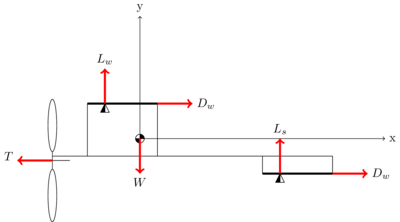

In [7]:
%%tikz -l calc

% draw axes

\draw[thin,->] (2.5,0.5) -- (2.5,4) node[above]{y};
\draw[thin,->] (2.5,0.5) -- (9.5,0.5) node[right]{x};

\newcommand{\model}{
    % body line
    \draw (0,0) -- (4,0);
    %tail boom line
    \draw (4,0) -- (8,0);
    \draw (1,0) -- (1,1.5);
    \draw (3,0) -- (3,1.5);
    
    % wing
    \draw [ultra thick] (1,1.5) -- (3,1.5);
    \draw (6,0) -- (6,-0.5);
    \draw (8,0) -- (8,-0.5);
    \draw [ultra thick] (8,-0.5) -- (6,-0.5);
    
    % prop
    \draw (0,-0.375) -- (0,0.125);
    \draw (0,-1.125) ellipse (0.125 and 0.75);
    \draw (0,0.875) ellipse (0.125 and 0.75);
    \draw[thin] (0,-0.125) -- (0.5,-0.125);
}

\newcommand{\wingac}[2] {
    \draw[fill=black] (#1,#2) -- (#1-0.125,#2-0.25) -- (#1, #2-0.25) -- cycle;
    \draw (#1,#2) -- (#1+0.125,#2-0.25) -- (#1, #2-0.25) -- cycle;
}

\newcommand{\cg}[2]{
    \draw [fill=black](#1,#2) -- 
        ++(+0.125,0) arc (0:90:0.125) -- 
        ++(0,-0.25) arc (270:180:0.125) -- (#1,#2);%
        \draw (#1,#2) circle (0.125);%
}
\model
\wingac{1.5}{1.5}
\wingac{6.5}{-0.5}
\cg{2.5}{0.5}

% wing lift and drag
\draw[red,ultra thick,->] (1.5,1.5) -- (1.5,2.5);
\node[above] at (1.5,2.5) {$L_w$};
\draw[red,ultra thick,->] (3,1.5) -- (4,1.5);
\node[right] at (4,1.5) {$D_w$};
            
% stab lift and drag
\draw[red,ultra thick,->] (6.5,-0.5) -- (6.5,0.5);
\node[above] at (6.5,0.5) {$L_s$};
\draw[red,ultra thick,->] (8,-0.5) -- (9,-0.5);
\node[right] at (9,-0.5) {$D_w$};
            
% thrust
\draw[red,ultra thick,->] (0,-0.125) -- (-1,-0.125);
\node[left] at (-1,0) {$T$};
\draw[ultra thin] (0,-0.125) -- (0.25,-0.125);
            
% weight
\draw[red,ultra thick,->] (2.5,0.5) -- (2.5,-0.5);
\node[below] at (2.5,-0.5) {$W$};          

This model has a wing and stab offset from the body center line. We also allow for a thrust offset. The center of gravity is marked, together with aerodynamic centers on the wing and stab. These are the points where forces are assumed to act.

In order to maintain level flight, all of the applied forces must be balanced. Therefore the lift must equal the weight, the thrust must equal the drag, and here is no tendency to pitch up or down. Our reference point in these calculations is the center of gravity, which is not shown on the Wart plans, but we can figure out the location from other data.  

## Locating the Center of Gravity

The Wart plans show weights for all of the major model components. We can figure out the center of gravity using those weights and the center of mass location of those parts. OpenSCAD can give us that data directly, but a little geometry will be sufficient here.

Here are the weights from the plans:

In [15]:
import pint
u = pint.UnitRegistry()

In [24]:
weights = {
    'motor_stick': 0.22*u.grams,
    'tail_boom': 0.08*u.grams,
    'stab': 0.25*u.grams,
    'wing': 0.42*u.grams,
    'prop': 0.23*u.grams,
    'rubber': 0.86*u.grams
}

Here is a bit of code that calculates the total weight:

In [25]:
total_weight = 0
for key in weights:
    total_weight += weights[key]
    
print('total weight = ',total_weight)

total weight =  2.06 gram


We can estimate the **CG** location by balancing the model, both horizontally, and vertically.

The definition of the *center of mass* for a collection of objects is:

\begin{equation}
{cg}_x = \frac{\sum^{n}_{i=1}x_i W_i}{\sum^{n}_{i=1}W_i}
\end{equation}

\begin{equation}
{cg}_y = \frac{\sum^{n}_{i=1}y_i W_i}{\sum^{n}_{i=1}W_i}
\end{equation}

The reference point for these calculations can be any convenient point. We will use the nose of the motor stick. All dimensions were derived from the plans.

(TODO: all of these need to be fixed):

In [26]:
cg_arms = {
    'prop': (0*u.inch,-0.125*u.inch),
    'wing': (2.25*u.inch, (7/8)*u.inch),
    'stab': ((6+8.5-1)*u.inch,0*u.inch),
    'motor_stick': (4*u.inch,0.0625*u.inch),
    'tail_boom': (7.0*u.inch,0*u.inch),
    'rubber': (3*u.inch,-0.125*u.inch)
}

Each of these locations is. shown as an **(x,y)** pair. We need both values to locate the **CG** correctly. Yes, it is tedious to add units to the numbers, but the results will justify adding them.

Here is code to calculate the model weight:

In [27]:
   def cg(w,a):
    x_cg = 0
    y_cg = 0
    W_sum = 0
    for key in w:
        x_cg += w[key] * a[key][0]
        y_cg += w[key] * a[key][1]
        W_sum += w[key]
    x_cg = x_cg/W_sum
    y_cg = y_cg/W_sum
    print(f'CG is at ({x_cg},{y_cg})')
        
cg(weights, cg_arms)

CG is at (4.048543689320388 inch,0.11893203883495145 inch)


That puts the **CG** slightly behind the tailing edge of the wing. 

Before we move on, let's gather some data from the plans and calculate a few area and lengths we will need.

In [38]:
import math

# define basic dimensions from plan
wing = {
    'center_span': 8 * u.inches,
    'center_chord': 2 * u.inches,
    'tip_span':3.75 * u.inches,
    'tip_chord': 1.75 * u.inches,
    'tip_dihedral': 7/8*u.inches,
}

stab = {
    'tip_span': (5 + 7/16) * u.inches,
    'center_chord': 1.75 * u.inches,
    'tip_chord': 1 * u.inches,
    'tip_dihedral': 7/8 * u.inches
}

## add calculated dimensions needed in later work
wing['tip_angle'] = math.atan(wing['tip_dihedral']/wing['tip_span'])
stab['tip_angle'] = math.atan(stab['tip_dihedral']/stab['tip_span']/2)
wing['projected_area'] = \
    wing['center_span'] * wing['center_chord'] \
     + 2 * (wing['center_chord'] + wing['tip_chord'])/2 *\
    wing['tip_span'] * math.cos(wing['tip_angle'])
stab['projected_area'] = 2 * stab['tip_span'] * (stab['center_chord'] 
                + stab['tip_chord'] )/2\
         * math.cos(stab['tip_angle'])
stab['projected_span'] = 2 * stab['tip_span'] * math.cos(stab['tip_angle'])
wing['projected_span'] = wing['center_span'] + 2 * \
    wing['tip_span'] * math.cos(wing['tip_angle'])
wing['mean_chord'] = wing['projected_area']/wing['projected_span']
stab['mean_chord'] = stab['projected_area']/stab['projected_span']
stab['te_to_ac'] = 0.75 * stab['mean_chord']
wing['te_to_ac'] = 0.75 * wing['mean_chord']

Here is a utility routine to print our the data we have created:

In [39]:
def print_dict(d, title):
    print(title)
    for key in d:
        print(f'\t{key}: {d[key]}')

In [40]:
print_dict(wing,"wing data")
print_dict(stab, "stab_data")

wing data
	center_span: 8 inch
	center_chord: 2 inch
	tip_span: 3.75 inch
	tip_chord: 1.75 inch
	tip_dihedral: 0.875 inch
	tip_angle: 0.22923193327699534
	projected_area: 29.694642011993967 inch ** 2
	projected_span: 15.303809073063448 inch
	mean_chord: 1.940343209342576 inch
	te_to_ac: 1.4552574070069322 inch
stab_data
	tip_span: 5.4375 inch
	center_chord: 1.75 inch
	tip_chord: 1 inch
	tip_dihedral: 0.875 inch
	tip_angle: 0.08028681528301647
	projected_area: 14.90495716456054 inch ** 2
	projected_span: 10.83996884695312 inch
	mean_chord: 1.375 inch
	te_to_ac: 1.03125 inch


## Aerodynamic Centers

Flying surfaces generate aerodynamic forces by creating a pressure distribution on their surfaces as they move. We can integrate this pressure distribution to find the total force that will be generated, and locate that force. This point is called the *center of pressure*. Unfortunately, the center of pressure  point varies with angle of attack. For that reason, aerodynamics researchers prefers to use an *aerodynamic center* as the point where forces will be applied. Doing this requires the addition of a moment force to ensure that the total force are correct. The aerodynamic center is commonly set at 1/4 of the mean chord of each surface. 

The mean chord is found using:

\begin{equation}
c_m = S / b
\end{equation}

Where $S$ is the projected surface area, and $b$ is the projected span.

## estimating Lift

In [22]:
arms = {
    'thrust': (-2.5 * u.inch, -0.125*u.inch),
    'weight': (0*u.inch,0*u.inch),
    'wing_ac': (-1*u.inch,1*u.inch),
    'stab_ac': (4*u.inch,-1*u.inch),
}

In [9]:
forces = {
    'thrust': 0.05*u.grams,
    'weight': 2.06*u.grams,
    'lift_wing': 1.5*u.grams,
    'drag_wing': 0.03*u.grams,
    'lift_stab': -0.4*u.grams,
    'drag_stab': 0.015*u.grams
}

We can now write a simple function that determines the moment around the **CG** for given values of the various terms. To simplify this function, we will create a Python dictionary holding the values.

It should be apparent that all six force vectors need to be considered, since none of them (except weight) align with the center of gravity. 

In [8]:
import pint
u = pint.UnitRegistry()

We need to estimate the location of the center of gravity. The Wart plans shows some data we can use:

In [12]:
def moment(a,f, debug=False):
    
    # thrust moment
    ta = a['thrust'][1] # y 
    tf = f['thrust']
    tm = ta * tf
    if debug:
        print("Thrust moment:",tm)
    # weight  - no moment, but we will calculate it anyway
    wa = a['weight'][0]
    wf = f['weight']
    wm = wa * wf
    if debug:
        print("Weight moment:",wm)
    
    # wing lift moment
    wla = a['wing_ac'][0]
    wlf = f['lift_wing']
    wlm = wla * wlf
    if debug:
        print("Wing lift moment:",wlm)
    
    # wing drag moment
    wda = a['wing_ac'][1]
    wdf = f['drag_wing']
    wdm = wda * wdf
    if debug:
        print("Wing drag moment:",wdm)    
    
    # stab lift moment
    sla = a['stab_ac'][0]
    slf = f['lift_stab']
    slm = sla * slf
    if debug:
        print("Stab lift moment:",slm)    
    
    # stab drag moment
    sda = a['stab_ac'][1]
    sdf = f['drag_stab']
    sdm = sda * sdf 
    if debug:
        print("Stab drag moment:",sdm)
        
    total_moment = tm + wm + wlm + wdm + slm + sdm 
    print('total moment =',total_moment)


In [13]:
moment(arms, forces, debug=True)

Thrust moment: -0.00625 gram * inch
Weight moment: 0.0 gram * inch
Wing lift moment: -1.5 gram * inch
Wing drag moment: 0.03 gram * inch
Stab lift moment: -1.6 gram * inch
Stab drag moment: -0.015 gram * inch
total moment = -3.09125 gram * inch


By convention, a positive moment pitched the node up. So this one is going to fly about like many of my  first flights!

For stable level flight, the total moment needs to be zero. Obviously, I threw in random values here, and our goal is to produce all of these numbers from our design and a little help from aerodynamics theory.

The nice thing about using code to help us make these calculations is that we can run parametric tests and see results quickly, We will use that fact later.

## Aerodynamic forces

The forces generated by the wing and stab depend on the airfoils we use and the actual flight conditions. Since most bulders use simple circular arc airfoils, I went in search of data on common thicknesses. The Wart uses a 4% arc on the wing, and a 2% arc on the stab. Of course, I could not find any usable data for those airfoils, but I did find data for a 6% and a 3% arch airfoils that will at least let us begin this development.

Let's get some data from the wart plans, and use **pint** to track units:

let's see what we have now:

In [94]:
dict_print(wing)

center_span: 8 inch
center_chord: 2 inch
tip_span: 3.75 inch
tip_chord: 1.75 inch
tip_dihedral: 0.875 inch
tip_angle: 0.22923193327699534
projected_area: 29.694642011993967 inch ** 2
projected_span: 15.303809073063448 inch
mean_chord: 1.940343209342576 inch
te_to_ac: (0, <Quantity(145.525741, 'inch')>)


In [95]:
dict_print(stab)

tip_span: 5.4375 inch
center_chord: 1.75 inch
tip_chord: 1 inch
tip_dihedral: 0.875 inch
tip_angle: 0.08028681528301647
projected_area: 14.90495716456054 inch ** 2
projected_span: 10.83996884695312 inch
mean_chord: 1.375 inch
te_to_ac: 1.03125 inch


We estimated the mean chord values by dividing the projected area by the projected span. The location of the mean aerodynamic centers for both surfaces is set at the quarter chord point. We will locate it from the trailing edges since both are straight on the plans.



The lift and drag forces will be calculated using the definitions of the lift and drag coefficients:
    
\begin{equation}
C_l = \frac{2L}{\rho u^2 S}
\end{equation}

or

\begin{equation}
L = \frac{1}{2}\rho u^2 C_l S
\end{equation}

IN these equations, **L** and **D** are the lift forces, **S** is the surface area of the wing or stab, $\rho$ is the air density and **u** is the flight velocity. 

Similarly:

\begin{equation}
D = \frac{1}{2}\rho u^2 C_d S
\end{equation}

Formally, we should also include the moment coefficient, which accounts for the center of pressure not falling exactly at the aerodynamic center

\begin{equation}
M = \frac{1}{2}\rho u^2 C_n S c
\end{equation}

Where **c** is the mean chord.

For testing purposes, we will use these values for density and velocity:



In [100]:
flight = {
    'density': 0.00231683 *u.slugs/u.ft**3,
    'dynamic_viscosity': 0.0000180338 * u.pascal * u.second,
    'velocity': 2.0 * u.mph
}
flight['kinematic_viscosity'] = flight['dynamic_viscosity']/flight['density']
flight['q'] = 0.5* (flight['density'] * flight['velocity'] ** 2)
flight['wing_re'] = flight['density'] * flight['velocity'] * wing['mean_chord'] / flight['dynamic_viscosity']
flight['stab_re'] = flight['density'] * flight['velocity'] * stab['mean_chord'] / flight['dynamic_viscosity']

dict_print(flight)

density: 0.00231683 slug / foot ** 3
dynamic_viscosity: 1.80338e-05 pascal * second
velocity: 2.0 mile_per_hour
kinematic_viscosity: 0.007783825313035483 foot ** 3 * pascal * second / slug
q: 0.00463366 mile_per_hour ** 2 * slug / foot ** 3
wing_re: 498.557747973379 inch * mile_per_hour * slug / foot ** 3 / pascal / second
stab_re: 353.29672614756737 inch * mile_per_hour * slug / foot ** 3 / pascal / second


In [102]:
wing_re = flight['wing_re'].to_base_units()
wing_re

2917.575722064471 <Unit('dimensionless')>

In [104]:
stab_re = flight['stab_re'].to_base_units()
stab_re

2067.5036243705945 <Unit('dimensionless')>

Getting airfoil data for these Reynolds Numbers is not easy. McLean arbitrarily used a $C_lw$ of 1.0, and calculated the required $C_ls* to balance moments. He used pitching moment coefficient values of -0.10 and -0.05 for the wing and stab.He did not include any other forces. 

Rather than just use these numbers, we will use the most basic theories of aerodynamics to estimate the coefficients. 

*Thin Airfoil Theory*, is often used as a first approximation for calculating lift and pitching moment data. If we use *Prandtl's Lifting Line Theory* we can get an approximation for the induced drag, and profile drag which together as the major sources of drag at low speeds.

we can estimate the $C_d$ values by examining typical lift/drag curves. 
